In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder , normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from scipy import stats
from imblearn.under_sampling import NearMiss

In [52]:
train1 = pd.read_csv("click_data_train_1.csv" , index_col=[0])

In [92]:
train3 = pd.read_csv("click_data_train_3.csv" , index_col=[0])

In [59]:
train1.head()

,display_id,ad_id,clicked,uuid,document_id_x,timestamp,platform,geo_location,source_id,publisher_id,publish_time,document_id_y,campaign_id,advertiser_id
0,2,125211,0,79a85fa78311b9,1794259,81,2,US>CA>807,93.0,407.0,2016-06-14 00:00:00,876083,16054,772
1,7109,125211,1,e0f0e15a32b74c,1767119,488035,2,US>AL>698,8548.0,435.0,2016-06-13 13:00:00,876083,16054,772
2,2,156535,0,79a85fa78311b9,1794259,81,2,US>CA>807,93.0,407.0,2016-06-14 00:00:00,630534,16636,380
3,2,169564,0,79a85fa78311b9,1794259,81,2,US>CA>807,93.0,407.0,2016-06-14 00:00:00,1394819,20109,640
4,37,169564,0,d4f62cdcb39ad8,1779285,2687,2,US>WA>819,93.0,407.0,2016-06-13 17:00:00,1394819,20109,640


In [60]:
train2.head()

,display_id,ad_id,clicked,uuid,document_id_x,timestamp,platform,geo_location,source_id,publisher_id,publish_time,document_id_y,campaign_id,advertiser_id
0,9797,162994,0,1b32fdf96bc27a,964380,678426,2,US>MN>613,7031.0,637.0,2014-07-18 00:00:00,1408591,20413,1031
1,10545,162994,0,929f71c502d117,868169,731504,2,US>KY>529,9777.0,167.0,2015-09-25 14:00:00,1408591,20413,1031
2,11414,162994,0,b7876d42c7229f,868169,792228,2,US>TX>633,9777.0,167.0,2015-09-25 14:00:00,1408591,20413,1031
3,11981,162994,1,a6a85025b3a76f,868169,836012,2,US>TX>623,9777.0,167.0,2015-09-25 14:00:00,1408591,20413,1031
4,9995,162994,0,72fcce3631e574,1373190,690803,2,US>MD>511,2902.0,56.0,2016-05-01 00:00:00,1408591,20413,1031


In [2]:
train = pd.read_csv('train_features.csv')

In [6]:
train.isna().sum()

Unnamed: 0       0
display_id       0
ad_id            0
clicked          0
uuid             0
document_id_x    0
timestamp        0
platform         0
geo_location     0
source_id        0
publisher_id     0
publish_time     0
document_id_y    0
campaign_id      0
advertiser_id    0
doc_timestamp    0
country          0
uuid_c           0
dtype: int64

In [7]:
train["clicked"].value_counts()

0    103240
1     24629
Name: clicked, dtype: int64

In [8]:
# is_NaN = train.isnull()
# row_has_NaN = is_NaN.any(axis=1)
# df[row_has_NaN]

In [9]:
def add_timestamp (row):
    return datetime.timestamp(datetime.strptime(str(row["publish_time"]) , '%Y-%m-%d %H:%M:%S'))

In [10]:
def get_country (row , le) :
    country = str(row["geo_location"]).split('>')[0]
    inp = list()
    inp.append(country)
    return le.transform(inp)[0]

In [11]:
def get_state (row):
    geos = str(row["geo_location"]).split('>')
    if len(geos) == 1 :
        geos.append(np.nan)
    return geos[1]

In [100]:
def get_categorical_uuid (row , le):
    inp = list()
    inp.append(row["uuid"])
    return le.transform(inp)[0]

In [101]:
def add_new_features (df):
    '''
    this function adds extra features to our dataset the features are as follows :
    1) doc_timestamp : publish time of the document 
    2) country : the country of where the user is clicking in the ad 
    3) state : the state of where the user is clicking in the ad
    4) uuid_c : the number that the uuid was mapped to 
    '''
    df["doc_timestamp"] = df.apply(add_timestamp , axis = 1)
    
    # creating label encoder for mapping each country to a number 
    vals = train.apply(lambda row : str(row["geo_location"]).split('>')[0] , axis = 1)
    le_country = LabelEncoder()
    u_vals_country = vals.unique() 
    le_country.fit(u_vals_country)
    df["country"] = df.apply(lambda row : get_country(row , le_country) , axis = 1)
    
    # deleted for now
    #df["state"] = df.apply(get_state , axis = 1)
    
    #creating categorical encoder in order to map each uuid to a class number 
    le_uuid = LabelEncoder()
    u_vals_uuid = df["uuid"].unique() 
    le_uuid.fit(u_vals_uuid)
    df["uuid_c"] = df.apply(lambda row : get_categorical_uuid(row , le_uuid) , axis = 1)
    return df

In [5]:
def clean_dataframe (df):
    #removing columns that are no longer useful
    cols_to_remove = ["publish_time" , "geo_location" , "uuid"]
    df = df.drop(cols_to_remove , axis = 1)
    
    #removing outliers 
    df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]
    
    #splitting the dataframe 
    X = df.drop("clicked" ,  axis = 1)
    y = df["clicked"]
    
    #normalizing inputs
    X_norm = normalize(X)
    return X , y 

In [104]:
# df = add_new_features(train)

In [3]:
# df.to_csv("train_features.csv")
df = train

In [6]:
X , y = clean_dataframe(df)

In [16]:
# X.head()

In [7]:
X_new = SelectKBest(chi2, k=6).fit_transform(X, y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.33, random_state=42)

In [9]:
# oversample = SMOTE()
# X_ov, y_ov = oversample.fit_resample(X_train, y_train)

In [10]:
# undersample = NearMiss(version=1, n_neighbors=3)
# X_uv, y_uv = undersample.fit_resample(X_train, y_train)

In [13]:
param_grid = {'criterion':['gini','entropy'],
              'max_depth': np.arange(3, 15) 
             }

In [14]:
class_weight = {
    1 : 5 , 
    0 : 1
}

In [15]:
model = GridSearchCV(DecisionTreeClassifier(class_weight = class_weight), param_grid)

In [327]:
# model = tree.DecisionTreeClassifier()

In [16]:
model.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                              class_weight={0: 1, 1: 5},
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_gr

In [26]:
y_pred = model.predict(X_test)

In [ ]:
metrics.roc_auc_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89     32812
           1       0.00      0.00      0.00      7998

    accuracy                           0.80     40810
   macro avg       0.40      0.50      0.45     40810
weighted avg       0.65      0.80      0.72     40810



C:\Users\Asus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
metrics.roc_auc_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))

0.5

In [314]:
score = metrics.roc_auc_score(y_test, y_pred)

In [315]:
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred)

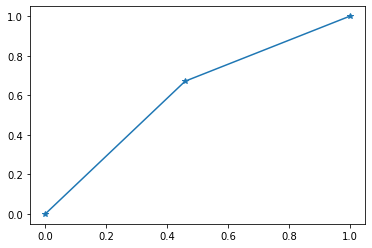

In [316]:
pyplot.plot(lr_fpr, lr_tpr, marker='*', label='decision-tree')

In [20]:
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC

In [21]:
model = SVC() 

In [22]:
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)